### Import dependences

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load dataset

In [2]:
data_path = "C:\\Jave\\Seasonality\\dataset.csv"

In [3]:
data = pd.read_csv(data_path)
data.head()

,date,quantity
0,02/12/2017,2.0
1,09/12/2017,2.0
2,15/12/2017,1.0
3,19/12/2017,2.0
4,21/12/2017,1.0


### Data analyzing

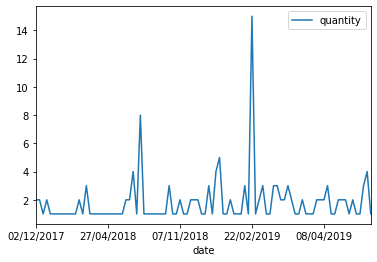

In [4]:
data.plot(x = 'date', y = 'quantity')

### Scale control variable

In [5]:
features_numericas = ['quantity']

In [6]:
scaled_features = {}

In [7]:
for item in features_numericas:
    mean, std = data[item].mean(), data[item].std()
    scaled_features[item] = [mean, std]
    data.loc[:, item] = (data[item] - mean)/std

In [8]:
print(data)

          date  quantity
0   02/12/2017  0.102783
1   09/12/2017  0.102783
2   15/12/2017 -0.465548
3   19/12/2017  0.102783
4   21/12/2017 -0.465548
..         ...       ...
89  26/04/2019 -0.465548
90  29/04/2019 -0.465548
91  30/04/2019  0.671114
92  02/05/2019  1.239445
93  04/05/2019 -0.465548

[94 rows x 2 columns]


### Dividindo os dados em treino, teste e validação

Salvaremos os últimos 21 dias dos dados para serem usados como um conjunto de testes depois de treinarmos a rede. Usaremos este conjunto para fazer previsões e compará-los com o número real de ciclistas.

In [10]:
# Salvando os últimos 21 dias
test_data = data[:20]
data = data[:20]

In [11]:
# Separando os dados em variáveis preditoras e variável target
target_fields = ['quantity']
features, targets = data.drop(target_fields, axis = 1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis = 1), test_data[target_fields]

print(features)
print(targets)

          date
0   02/12/2017
1   09/12/2017
2   15/12/2017
3   19/12/2017
4   21/12/2017
5   23/12/2017
6   06/01/2018
7   08/01/2018
8   12/01/2018
9   16/01/2018
10  23/01/2018
11  24/01/2018
12  26/01/2018
13  27/01/2018
14  03/02/2018
15  10/02/2018
16  14/02/2018
17  17/02/2018
18  05/04/2018
19  09/04/2018
    quantity
0   0.102783
1   0.102783
2  -0.465548
3   0.102783
4  -0.465548
5  -0.465548
6  -0.465548
7  -0.465548
8  -0.465548
9  -0.465548
10 -0.465548
11 -0.465548
12  0.102783
13 -0.465548
14  0.671114
15 -0.465548
16 -0.465548
17 -0.465548
18 -0.465548
19 -0.465548


Vamos dividir os dados em dois conjuntos, um para treinamento e outro para validação à medida que a rede está sendo treinada. Como se trata de dados de séries temporais, treinamos em dados históricos, então tentaremos prever os dados futuros (o conjunto de validação).

In [12]:
# Mantenha os últimos 60 dias dos dados restantes como um conjunto de validação
#train_features, train_targets = features[:60], targets[:60]
val_features, val_targets = features[60:], targets[60:]
#print(train_features)
print(train_targets)

NameError: name 'train_targets' is not defined

In [19]:
from datetime import date, timedelta
today = date.today()
begin = date.today()- timedelta(days=730)
print(today)
print(begin)

2019-11-21
2017-11-21


## Construindo a Rede Neural

Abaixo iremos construir a rede. Vamos configurar o Feed Forward e os hiperparâmetros: a taxa de aprendizado, o número de unidades ocultas e o número de passadas de treinamentos (epochs).

A rede possui duas camadas, uma camada oculta e uma camada de saída. A camada oculta usará a função sigmoid para ativações. A camada de saída tem apenas um nó e é usada para a regressão, a saída do nó é igual à entrada do nó. Ou seja, a função de ativação é $ f (x) = x $. Uma função que recebe o sinal de entrada e gera um sinal de saída, mas leva em consideração o limite (threshold), é chamada de função de ativação. Trabalhamos através de cada camada da nossa rede, calculando as saídas para cada neurônio. Todas as saídas de uma camada tornam-se entradas para os neurônios na próxima camada. Esse processo é chamado de * propagação direta * (Feed Forward).

Usamos os pesos para propagar os sinais para a frente, da entrada para as camadas de saída em uma rede neural. Usamos os pesos para propagar também o erro de trás da saída para a rede para atualizar nossos pesos. Isso é chamado * backpropagation *.

> ** Dica: ** Você precisará da derivada da função de ativação de saída ($ f (x) = x $) para a implementação de backpropagation. Se você não está familiarizado com o cálculo, esta função é equivalente à equação $ y = x $. Qual é a inclinação dessa equação? Essa é a derivada de $ f (x) $.

In [ ]:
# Classe da Rede Neural
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate, verbose = False):
        
        # Defina o número de nós nas camadas de entrada, oculta e de saída.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Inicializando os pesos
        self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.input_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5, 
                                       (self.output_nodes, self.hidden_nodes))
        self.lr = learning_rate
        
        self.verbose = verbose 
        
        if self.verbose:
            print("Rede Neural iniciada com:\ninput_nodes: {}\nhidden_nodes: {}\noutput_nodes: {}\nlearning_rate: {}\n".format(
                self.input_nodes, self.hidden_nodes, self.output_nodes, self.lr
            ))
        
        self.hidden_layer_activation_function = lambda x: 1 / (1 + np.exp(-x))
        self.hidden_layer_derivate_activation_function = lambda sigmoid: sigmoid * (1 - sigmoid)
        self.output_layer_activation_function = lambda x: x 
        self.output_layer_derivate_activation_function = lambda x: 1 
        
        # Ativação
        self.activation_function = self.hidden_layer_activation_function 
    
    def forward_pass(self, inputs):
        
        # Forward pass #
        
        # Sinais da camada de entrada
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs) 
        
        # Sinais da camada oculta
        hidden_outputs = self.hidden_layer_activation_function(hidden_inputs) 
        
        # Sinais na camada de saída final
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs) 
        final_outputs = self.output_layer_activation_function(final_inputs)
        return [hidden_inputs, hidden_outputs, final_inputs, final_outputs]
    
    def backward_pass(self, inputs, targets, hidden_inputs, hidden_outputs, final_inputs, final_outputs):
        
        # Backward pass #
        output_errors = targets - final_outputs
        output_grad = self.output_layer_derivate_activation_function(final_outputs)
        
        # Backpropagated error
        
        # Erros propagados para a camada oculta
        hidden_errors = output_errors * output_grad * self.weights_hidden_to_output 
        hidden_grad = self.hidden_layer_derivate_activation_function(hidden_outputs)
            
        return [output_errors, hidden_errors, hidden_grad, output_grad]

    def train(self, inputs_list, targets_list):
        
        # Converta a lista de entradas para a matriz 2d
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        
        hidden_inputs, hidden_outputs, final_inputs, final_outputs = self.forward_pass(inputs)
        output_errors, hidden_errors, hidden_grad, output_grad = self.backward_pass(inputs, targets, hidden_inputs, hidden_outputs, final_inputs, final_outputs)

        # Atualização de pesos para saída com passo de descida de gradiente
        self.weights_hidden_to_output += self.lr * np.dot(output_errors * output_grad, hidden_outputs.T) 
        self.weights_input_to_hidden += self.lr * np.dot(hidden_errors.T * hidden_grad, inputs.T)
 
    def run(self, inputs_list):
        # Executa um passo para a frente pela rede
        inputs = np.array(inputs_list, ndmin = 2).T
        
        _, _, _, final_outputs = self.forward_pass(inputs)
        return final_outputs

In [ ]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

In [ ]:
print(data)

## Treinando a Rede

Aqui você configurará os hiperparâmetros da rede. A estratégia é encontrar hiperparâmetros, de modo que o erro no conjunto de treinamento seja baixo, mas você não tenha overfitting. Se você treinar a rede por muito tempo ou tiver muitos nós ocultos, pode tornar-se excessivamente específico para o conjunto de treinamento e não conseguirá generalizar para o conjunto de validação. Ou seja, a perda no conjunto de validação começará a aumentar à medida que a queda do conjunto de treinamento cai.

Você também usará um método conhecido como Descida de Gradiente Estocástica (SGD) para treinar a rede. A idéia é que, para cada passagem de treinamento, você pega uma amostra aleatória dos dados em vez de usar todo o conjunto de dados. Você usa muito mais passagens de treinamento do que com descida de gradiente normal, mas cada passagem é muito mais rápida. Isso acaba treinando a rede de forma mais eficiente. Você aprenderá mais sobre o SGD mais tarde.

### Escolhendo número de epochs
Este é o número de vezes que o conjunto de dados passará pela rede, cada vez que atualizar os pesos. À medida que o número de épocas aumenta, a rede se torna melhor e melhor em prever os alvos no conjunto de treinamento. Você precisará escolher épocas suficientes para treinar a rede bem, mas não demais, ou você terá overfitting.

### Escolhendo a taxa de aprendizagem
Isso reduz o tamanho das atualizações de peso. Se essa taxa for muito grande, os pesos tendem a explodir e a rede não consegue se ajustar aos dados. Uma boa escolha para começar é 0.1. Se a rede tiver problemas ao ajustar os dados, tente reduzir a taxa de aprendizado. Note-se que quanto menor for a taxa de aprendizagem, menores as etapas nas atualizações de peso e quanto maior, demora a convergir a rede neural.

### Escolhendo o número de nodes ocultos
Os nós mais ocultos que você tem, as previsões mais precisas que o modelo fará. Experimente alguns números diferentes e veja como isso afeta o desempenho. Você pode observar o dicionário de perdas para uma métrica da performance da rede. Se o número de unidades escondidas for muito baixo, então o modelo não terá espaço suficiente para aprender e, se for muito alto, há muitas opções para a direção que a aprendizagem pode levar. O truque aqui é encontrar o equilíbrio certo no número de unidades escondidas que você escolher.

In [ ]:
import sys

# Configurando os hiperparametros
epochs = 3000
learning_rate = 0.1
hidden_nodes = 27
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate, True)

losses = {'train':[], 'validation':[]}

for e in range(epochs):
    # Percorrer um lote aleatório de 128 registros do conjunto de dados de treinamento
    batch = np.random.choice(train_features.index, size=128)
    for record, target in zip(train_features.iloc[batch].values, 
                              train_targets.iloc[batch]['quantity']):
        network.train(record, target)
    
    # Imprimir o progresso do treinamento
    train_loss = MSE(network.run(train_features), train_targets['quantity'].values)
    
    val_loss = MSE(network.run(val_features), val_targets['quantity'].values)
    
    sys.stdout.write("\rProgresso: " + str(100 * e/float(epochs))[:4] \
                     + "% ... Erro no Treinamento: " + str(train_loss)[:5] \
                     + " ... Erro na Validação: " + str(val_loss)[:5])
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

O número de epochs como 3000 é uma boa escolha em si, mas a combinação de hiperparâmetros deve ser ajustada adequadamente. Tente sintonizar todos os hiperparâmetros em paralelo. As perdas de treinamento e validação são aceitáveis. Ao observar o gráfico de perda de treinamento-validação, você não acha que há muito ruído nos dados? Isso pode ser melhorado ajustando corretamente os hiperparâmetros. Tente testar com várias combinações e observe a resposta do modelo. O número de iterações deve ser escolhido para que a perda de treinamento seja baixa e a perda de validação não aumente.

Às vezes, a rede não converge quando a taxa de aprendizado é de 0.1. As etapas de atualização de peso são muito grandes com essa taxa de aprendizado e os pesos acabam por não convergir. Devido à alta taxa de aprendizado, o modelo ignora os pontos mínimos. Ao diminuir a taxa de aprendizagem, você pode obter menor perda de validação e o ruído no gráfico também diminuirá. Tente observar a resposta do modelo para valores como 0.08, 0.05, 0.01, 0.008, etc.

In [ ]:
plt.plot(losses['train'], label = 'Erro no Treinamento')
plt.plot(losses['validation'], label = 'Erro na Validação')
plt.legend()
plt.ylim(ymax = 0.5)

## Fazendo as Previsões

Aqui, usamos os dados do teste para ver como a rede está modelando os dados. Se algo estiver completamente errado, certifique-se de que cada etapa da sua rede esteja implementada corretamente.

In [ ]:
fig, ax = plt.subplots(figsize = (8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features)*std + mean
ax.plot(predictions[0], label = 'Previsões')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right = len(predictions))
ax.legend()

dates = pd.to_datetime(df.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## Avaliando os Resultados
 
Responda estas perguntas sobre seus resultados. Quão bem o modelo prediz os dados? Onde ele falha? Por que ele falha?

> O modelo parece ter resultados bastante decentes, mas a precisão da previsão parece diminuir à medida que avançamos no tempo (a partir de 21 de dezembro). Este fenômeno provavelmente deve-se à existência de variáveis que poderiam ter acontecido entre 21 de dezembro e 31 de dezembro (parece suspeito, pois é o período das celebrações, muitos eventos inesperados podem acontecer durante esse lapso de tempo, o que poderia levar as pessoas a alugar mais bicicletas do que durante um período normal)

# Fim